# Single Fit

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd 
from BHDVCS_tf import TFBHDVCS
from BHDVCS_torch import TBHDVCS

# import BHDVCS_fit as dvcsfit

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import chisquare

### Load functions and choose set to fit
change setnum to choose which set to fit

In [23]:
tb = TBHDVCS()

f = tb.TotalUUXS_curve_fit

loss_func = tb.loss_MSE_errs

setnum = 8
a = setnum*36
b = a + 36

### Load in data

In [4]:
dats = pd.read_csv('dvcs_psuedo.csv')

n = np.array(dats['#Set'])[a:b]
ind = np.array(dats['index'])[a:b]
k = np.array(dats['k'])[a:b]
qq = np.array(dats['QQ'])[a:b]
xb = np.array(dats['x_b'])[a:b]
t = np.array(dats['t'])[a:b]
phi = np.array(dats['phi_x'])[a:b]
ydat = np.array(dats['F'])[a:b]  
errF = np.array(dats['errF'])[a:b]  
F1 = np.array(dats['F1'])[a:b]  
F2 = np.array(dats['F2'])[a:b]  
const = np.array(dats['dvcs'])[a:b]  
ReH_target = np.array(dats['ReH'])[a:b]  
ReE_target = np.array(dats['ReE'])[a:b]  
ReHT_target = np.array(dats['ReHtilde'])[a:b]

### Set pytorch variables
***Note: BHDVCS.py file must be changed so that all functions are pytorch***

In [5]:
xdat = np.asarray([phi, qq, xb, t, k, F1, F2, const])
x = Variable(torch.from_numpy(xdat[1:5].transpose()))
y = Variable(torch.from_numpy(ydat.transpose()))
xdat = Variable(torch.from_numpy(xdat))
errs = Variable(torch.from_numpy(errF))

## Network Architecture:
Inputs: 36 instances of 4 variables (qq, xb, t, kk) \
Outputs: 3 compton form factors \
Loss: Mean of squares between F(net outputs) vs F(given)

In [6]:
net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 80),
        torch.nn.Tanh(),
        torch.nn.Linear(80, 3)
    )

### Set optimizer and choose number of epochs

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=.02)
EPOCH = 2500

losses = []
losses.clear()

### Train Network

In [34]:
print("Training Set %d" % (setnum))
for epoch in range(EPOCH):
    p = net(x[0].float()) #output 3 predicted values for cffs
    
    ReHfit = p[0]
    ReEfit = p[1]
    ReHTfit = p[2]
    loss = loss_func((xdat.float()), ReHfit, ReEfit, ReHTfit, errs, y)
    losses.append(float(loss.data.float()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Training Complete")

Training Set 8


ValueError: not enough values to unpack (expected 8, got 4)

### Show final fit statistics

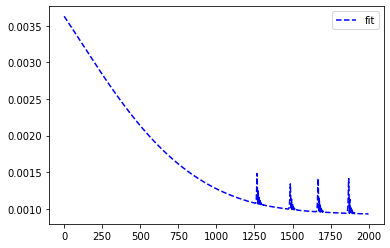



      Fit Value of ReH = 11.41
   Actual Value of ReH = 12.55
           Error (ReH) = 9.1%

      Fit Value of ReE = -46.52
   Actual Value of ReE = -52.55
           Error (ReE) = 11.5%

     Fit Value of ReHT = 7.33
  Actual Value of ReHT = 6.97
          Error (ReHT) = 5.1%

MSE Loss Value for this fit: 9.292e-04
Average Error for set #8 using ANN = 8.59%
Average Error for set #8 using scipy = 5.51%


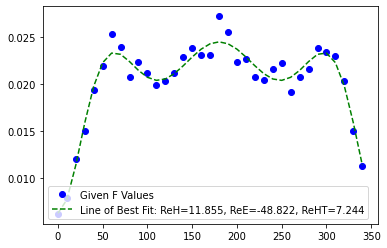

(5.571635345945568, 7.103719588945344, 3.855825921010846)

In [8]:
plt.plot(losses[int(EPOCH*0.2):], 'b--', label='fit')
plt.legend()
plt.show()

ReHfit = p[0].float()
ReEfit = p[1].float()
ReHTfit = p[2].float()

err_H = abs(100*(abs(ReHfit-ReH_target[0]))/ReH_target[0])
err_E = abs(100*(abs(ReEfit-ReE_target[0]))/ReE_target[0])
err_HT = abs(100*(abs(ReHTfit-ReHT_target[0]))/ReHT_target[0])
    
print('\n\n%25s%.2f' % ('Fit Value of ReH = ', ReHfit))
print('%25s%.2f' % ('Actual Value of ReH = ', ReH_target[0]))
print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReH) = ', err_H))

print('%25s%.2f' % ('Fit Value of ReE = ', ReEfit))
print('%25s%.2f' % ('Actual Value of ReE = ', ReE_target[0]))
print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReE) = ', err_E))

print('%25s%.2f' % ('Fit Value of ReHT = ', ReHTfit))
print('%25s%.2f' % ('Actual Value of ReHT = ', ReHT_target[0]))
print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReHT) = ', err_HT))

# print('Chi-Squared Value for this fit: %.3e' % (chisquare(f(xdat,fit_cffs), ydat)[0]))
# print('Chi-Squared Value for expected fit: %.3e' % (chisquare(f(xdat,[ReH_target[0], ReE_target[0], ReHT_target[0]]), ydat)[0]))
print('MSE Loss Value for this fit: %.3e' % (float(loss.data.float())))
print('Average Error for set #%d using ANN = %.2f%%' % ((setnum), ((err_H+err_E+err_HT)/3)))
dvcsfit.fit_scipy(setnum)


# Finding Error of Fit for each Set:

In [40]:
dats = pd.read_csv('dvcs_psuedo.csv')
n = np.array(dats['#Set'])
ind = np.array(dats['index'])
k = np.array(dats['k'])
qq = np.array(dats['QQ'])
xb = np.array(dats['x_b'])
t = np.array(dats['t'])
phi = np.array(dats['phi_x'])
ydat = np.array(dats['F'])
errF = np.array(dats['errF']) 
F1 = np.array(dats['F1'])
F2 = np.array(dats['F2'])
const = np.array(dats['dvcs'])  
ReH_target = np.array(dats['ReH']) 
ReE_target = np.array(dats['ReE']) 
ReHT_target = np.array(dats['ReHtilde'])
errs_H = []
errs_E = []
errs_HT = []

EPOCH = 2500

arc = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 80),
        torch.nn.Tanh(),
        torch.nn.Linear(80, 3)
    )

# bads = [1, 4, 6, 8, 9, 11]

## Repeat steps above over each set in data
Print graph of loss decrease and fit, chi squared value of fit, and average error in form factors for both the neural net fit and our baseline scipy fit.

In [42]:
for datset in range(15):
    a = datset*36
    b = a + 36


    xdat = np.asarray([phi[a:b], qq[a:b], xb[a:b], t[a:b], k[a:b], F1[a:b], F2[a:b], const[a:b]])
    x = Variable(torch.from_numpy(xdat[1:5].transpose()))
    y = Variable(torch.from_numpy(ydat[a:b].transpose()))
    xdat = Variable(torch.from_numpy(xdat))
    errs = Variable(torch.from_numpy(errF[a:b]))

    net = arc
    
    optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
    
    losses = []
    losses.clear()
    
    print("Training Set %d..." % (datset))
    for epoch in range(EPOCH):
        p = net(x.float()) #output arrays for 3 predicted values for cffs

        hs = torch.transpose(p, 0, 1)[0] # array of 36 values for ReH at each increment of phi
        es = torch.transpose(p, 0, 1)[1] # array of 36 values for ReE at each increment of phi
        hts = torch.transpose(p, 0, 1)[2] # array of 36 values for ReHT at each increment of phi

        ReHfit = torch.mean(hs)
        ReEfit = torch.mean(es)
        ReHTfit = torch.mean(hts)

        cffs = [ReHfit, ReEfit, ReHTfit]

        loss = loss_func((xdat.float()), cffs, errs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Training Complete")
    
    ReHfits = (torch.transpose(p, 0, 1)[0]).data.numpy()
    ReEfits = (torch.transpose(p, 0, 1)[1]).data.numpy()
    ReHTfits = (torch.transpose(p, 0, 1)[2]).data.numpy()
    ReHfit = np.mean(ReHfits)
    ReEfit = np.mean(ReEfits)
    ReHTfit = np.mean(ReHTfits)
    errs_H.append(100*abs(float(ReHfit)-ReH_target[a])/ReH_target[a])
    errs_E.append(100*abs(float(ReEfit)-ReE_target[a])/ReE_target[a])
    errs_HT.append(100*abs(float(ReHTfit)-ReHT_target[a])/ReHT_target[a])
    print(100*abs(float(ReHfit)-ReH_target[a])/ReH_target[a])

#     plt.plot(losses[int(EPOCH/20):], 'b--', label='fit')
#     plt.legend()
#     plt.show()

#     print('\n\n%25s%.2f' % ('Fit Value of ReH = ', ReHfit))
#     print('%25s%.2f' % ('Actual Value of ReH = ', ReH_target[0]))
#     print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReH) = ', err_H))

#     print('%25s%.2f' % ('Fit Value of ReE = ', ReEfit))
#     print('%25s%.2f' % ('Actual Value of ReE = ', ReE_target[0]))
#     print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReE) = ', err_E))

#     print('%25s%.2f' % ('Fit Value of ReHT = ', ReHTfit))
#     print('%25s%.2f' % ('Actual Value of ReHT = ', ReHT_target[0]))
#     print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReHT) = ', err_HT))

#     # print('Chi-Squared Value for this fit: %.3e' % (chisquare(f(xdat,fit_cffs), ydat)[0]))
#     # print('Chi-Squared Value for expected fit: %.3e' % (chisquare(f(xdat,[ReH_target[0], ReE_target[0], ReHT_target[0]]), ydat)[0]))
#     print('MSE Loss Value for this fit: %.3e' % (float(loss.data.float())))
#     print('Average Error for set #%d using ANN = %.2f%%' % ((setnum), ((err_H+err_E+err_HT)/3)))
#     #dvcsfit.fit_scipy(setnum)

print('All sets complete.')

Training Set 0...
Training Complete
2.4074216375989788
Training Set 1...
Training Complete
6.468833317662575
Training Set 2...
Training Complete
7.791529385806948
Training Set 3...
Training Complete
11.827570297979282
Training Set 4...
Training Complete
6.68359595175567
Training Set 5...
Training Complete
6.418575735784835
Training Set 6...
Training Complete
13.415565149251512
Training Set 7...
Training Complete
10.562002039861428
Training Set 8...
Training Complete
6.2506676608950675
Training Set 9...
Training Complete
15.862573683692492
Training Set 10...
Training Complete
6.04219447945591
Training Set 11...
Training Complete
9.918596871837693
Training Set 12...
Training Complete
14.66619343265345
Training Set 13...
Training Complete
5.730742504618797
Training Set 14...
Training Complete
9.057470657067004
All sets complete.


In [43]:
print('\n\033[1m%s%.2f%%' % ('Avg. Error of ReH = ', sum(errs_H)/len(errs_H)))
# print('\033[1m%s%.2f\n' % ('Variance in Error of ReH = ', np.var(errs_H)))
print('\033[1m%s%.2f%%' % ('Avg. Error of ReE = ', sum(errs_E)/len(errs_E)))
# print('\033[1m%s%.2f\n' % ('Variance in Error of ReE = ', np.var(errs_E)))
print('\033[1m%s%.2f%%' % ('Avg. Error of ReHT = ', sum(errs_HT)/len(errs_HT)))
# print('\033[1m%s%.2f' % ('Variance in Error of ReHT = ', np.var(errs_HT)))


Avg. Error of ReH = 7.84%
Avg. Error of ReE = -8.21%
Avg. Error of ReHT = 6.33%


In [38]:
print(errs_H)

[tensor([  4.9583, 537.4485,  47.0899], grad_fn=<AbsBackward>), tensor([ 10.2244, 465.7125,  42.6480], grad_fn=<AbsBackward>), tensor([ 49.2714, 434.4655,  65.8134], grad_fn=<AbsBackward>), tensor([ 35.1499, 503.0112,  67.0625], grad_fn=<AbsBackward>), tensor([ 10.2792, 468.0311,  43.6707], grad_fn=<AbsBackward>), tensor([ 48.2170, 440.9309,  67.2830], grad_fn=<AbsBackward>), tensor([ 22.1322, 428.0266,  46.7324], grad_fn=<AbsBackward>), tensor([ 35.1916, 497.0955,  64.4684], grad_fn=<AbsBackward>), tensor([  9.8443, 470.7363,  44.4787], grad_fn=<AbsBackward>), tensor([ 37.9648, 510.4319,  75.8155], grad_fn=<AbsBackward>), tensor([ 48.0038, 442.1663,  67.7484], grad_fn=<AbsBackward>), tensor([ 18.9876, 446.9259,  49.9477], grad_fn=<AbsBackward>), tensor([ 38.6049, 506.7593,  75.3727], grad_fn=<AbsBackward>), tensor([ 47.8508, 443.1191,  67.7583], grad_fn=<AbsBackward>), tensor([ 18.2127, 451.4348,  51.6316], grad_fn=<AbsBackward>), 18.21163448703832, 0.06301712292561437, 0.066552703456

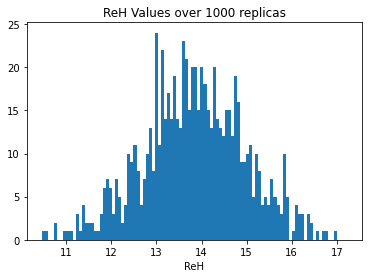

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import sys



ReHs = []
ReEs = []
ReHTs = []

original_stdout = sys.stdout

with open('all_reps.txt', 'r') as f:
    for line in f:
        # ReHs.append(int(f[l][1]))
        # ReEs.append(int(f[4]))
        # ReHTs.append(int(line[6]))
        if len(line.split()) > 1:
            ReHs.append(float(line.split()[1]))
            ReEs.append(float(line.split()[2]))
            ReHTs.append(float(line.split()[3]))

ReHs = np.asarray(ReHs)
ReEs = np.asarray(ReEs)
ReHTs = np.asarray(ReHTs)

meanReH = np.mean(ReHs)
varReH = np.var(ReHs)
meanReE = np.mean(ReEs)
varReE = np.var(ReEs)
meanReHT = np.mean(ReHTs)
varReHT = np.var(ReHTs)

plt.hist(ReHs, bins=100, range = (meanReH - 3*np.sqrt(varReH), meanReH + 3*np.sqrt(varReH)))
plt.title('ReH Values over 1000 replicas')
plt.xlabel('ReH')
plt.show()